# NOAA Interpolated Feature Data Explore

In [1]:
feature_data_dir = '../data/features'
processed_data_dir = '../data/processed'
media_dir = '../media'
figsize_width = 12
figsize_height = 8
output_dpi = 72

In [2]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import cartopy.crs as ccrs

In [3]:
# Variable setup
default_fig_size = (figsize_width, figsize_height)

In [4]:
# Load data
# - NOAA
data_to_load = ['surface', 'aloft', 'diff']
feature_data = dict()
for nm in data_to_load:
    fname = os.path.join(feature_data_dir, 'noaa_{}_interpolated_data.pkl'.format(nm))
    with open(fname, 'rb') as fin:
        feature_data[nm] = pickle.load(fin)

# - NASA
data_to_load = ['temperature_anomaly', 'sea_level', 'carbon_dioxide_levels']
nasa_data = dict()
for nm in data_to_load:
    fname = os.path.join(processed_data_dir, 'nasa_{}.pkl'.format(nm))
    with open(fname, 'rb') as fin:
        nasa_data[nm] = pickle.load(fin)

# - Hurricane data
fname = os.path.join(processed_data_dir, 'region_data.pkl')
with open(fname, 'rb') as fin:
    region_data = pickle.load(fin)

fname = os.path.join(processed_data_dir, 'region_yearly_data.pkl')
with open(fname, 'rb') as fin:
    region_yearly_df = pickle.load(fin)

fname = os.path.join(processed_data_dir, 'storm_track_data.pkl')
with open(fname, 'rb') as fin:
    storm_track_dict = pickle.load(fin)

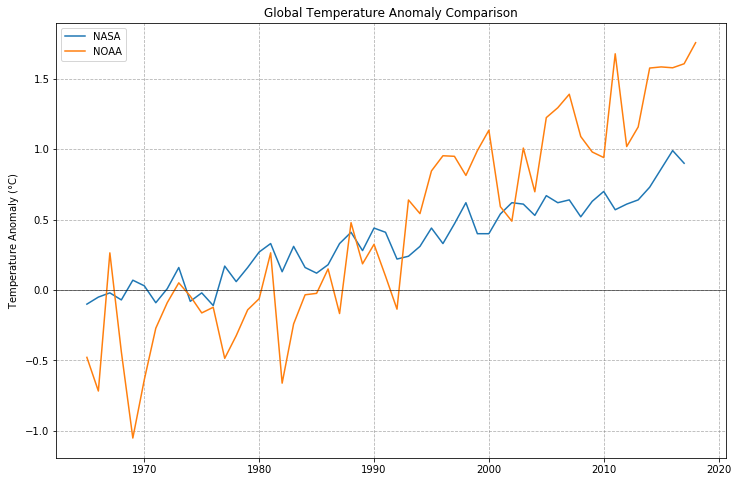

,NASA,NOAA
NASA,1.000000,0.865947
NOAA,0.865947,1.000000


In [5]:
# - Sanity check against NASA anomaly data just to see if we're close
nasa_tanom = nasa_data['temperature_anomaly'].copy().loc[:, 'Annual Mean']
nasa_tanom.name = 'NASA'

noaa_tanom = dict()
for k, v in feature_data['surface'].items():
    noaa_tanom[k] = v.flatten().mean()
noaa_tanom = pd.DataFrame.from_dict(noaa_tanom, orient='index', columns=['NOAA'])
noaa_tanom = noaa_tanom.groupby(noaa_tanom.index.year).mean()

fst_idx = max(noaa_tanom.first_valid_index(), nasa_tanom.first_valid_index())
tanom = pd.concat([nasa_tanom, noaa_tanom], axis=1).loc[fst_idx:]

# - Plot
fig, ax = plt.subplots(figsize=default_fig_size)

tanom.plot(ax=ax)
ax.axhline(0., color='black', linewidth=0.5)

ax.grid(True, linestyle='--', color='grey', alpha=0.6)
ax.set_title('Global Temperature Anomaly Comparison')
ax.set_ylabel('Temperature Anomaly ($\degree$C)')

fig.savefig(os.path.join(media_dir, 'nasa_noaa_anomaly_compare.png'), dpi=output_dpi)
plt.show();

# - Correlation table
tanom.corr()

In [6]:
# - Variables for plotting
region_names = ['North Atlantic', 'East Pacific', 'Western Pacific', 'Indian Ocean']
colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']
color_dict = dict(zip(region_names, colors))

In [7]:
# - Try to get start point for every storm in each region
cut_start = datetime(1965, 1, 1)
cut_end = datetime(2015, 12, 31)

regions_to_points = dict()
for region in region_names:
    regions_to_points[region] = list()
    strm_ids = region_yearly_df.loc[region_yearly_df.loc[:, 'Region']==region].index.unique()
    for sid in strm_ids:
        if sid in storm_track_dict.keys():
            if not storm_track_dict[sid]:
                continue
            st_dt = sorted(storm_track_dict[sid].keys())[0]
            if st_dt >= cut_start and st_dt <= cut_end:
                t_data = storm_track_dict[sid][st_dt]
                regions_to_points[region].append((t_data['Lon'], t_data['Lat']))


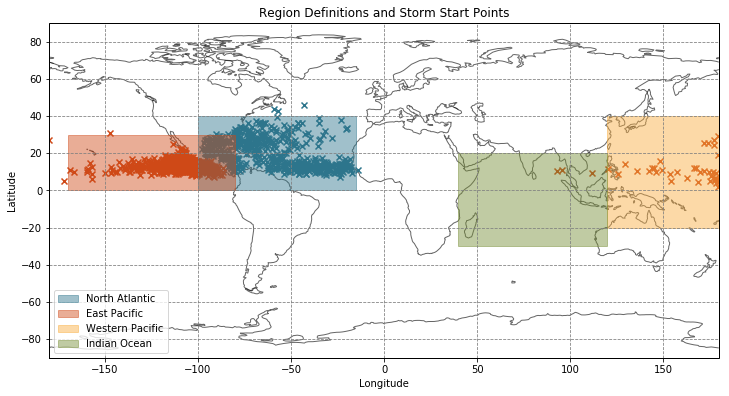

In [8]:
# - Specify Regions
region_cuts = {
    'North Atlantic': [(-100, -15), (0, 40)],
    'East Pacific': [(-170, -80), (0, 30)],
    'Western Pacific': [(120, 180), (-20, 40)],
    'Indian Ocean': [(40, 120), (-30, 20)]
}

# - Plot map to verify
fig = plt.figure(figsize=default_fig_size)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(zorder=0, color='black', alpha=0.6)

ax.set_title('Region Definitions and Storm Start Points')
ax.set_xlabel('Longitude')
ax.xaxis.set_visible(True)
ax.set_ylabel('Latitude')
ax.yaxis.set_visible(True)
ax.grid(True, color='grey', linestyle='--', alpha=1, zorder=1)

ax.set_global()
for region, (bnd_long, bnd_lat) in region_cuts.items():
    if regions_to_points[region]:
        plt_points = np.array(regions_to_points[region])
        ax.scatter(-abs(plt_points[:, 0]), plt_points[:, 1], color=color_dict[region], marker='x')
    x = bnd_long[0]
    y = bnd_lat[0]
    w = bnd_long[1] - bnd_long[0]
    h = bnd_lat[1] - bnd_lat[0]
    t_rect = mpatches.Rectangle(xy=(x, y), width=w, height=h, label=region, 
                                edgecolor=color_dict[region], 
                                facecolor=color_dict[region], alpha=0.45)
    ax.add_patch(t_rect)

ax.legend(loc='lower left')
fig.savefig(os.path.join(media_dir, 'region_areas_with_points.png'.format(nm)), 
            dpi=output_dpi)

plt.show();

In [9]:
# - Get data in regions of interest
cut_feature_data = dict()
for nm in feature_data.keys():
    cut_feature_data[nm] = dict()
    for region, bounds in region_cuts.items():
        long_bnd, lat_bnd = bounds[0], bounds[1]
        cut_feature_data[nm][region] = dict()
        for k, v in feature_data[nm].items():
            cut_feature_data[nm][region][pd.to_datetime(k)] = \
                feature_data[nm][k][long_bnd[0]+180:long_bnd[1]+180, 
                                    lat_bnd[0]+90:lat_bnd[1]+90]

In [10]:
# - Average the data across regions
average_data = dict()
for nm in cut_feature_data.keys():
    t_regdat = list()
    for region in region_cuts.keys():
        t_data = cut_feature_data[nm][region]
        o_data = dict()
        for dt, vals in t_data.items():
            if vals.size == 0:
                continue
            o_data[dt] = vals.flatten().mean()
        if len(o_data) == 0:
            continue
        t_frame = pd.DataFrame.from_dict(o_data, orient='index')
        t_frame.columns = [region]
        t_regdat.append(t_frame)
    average_data[nm] = pd.concat(t_regdat, axis=1, sort=True)

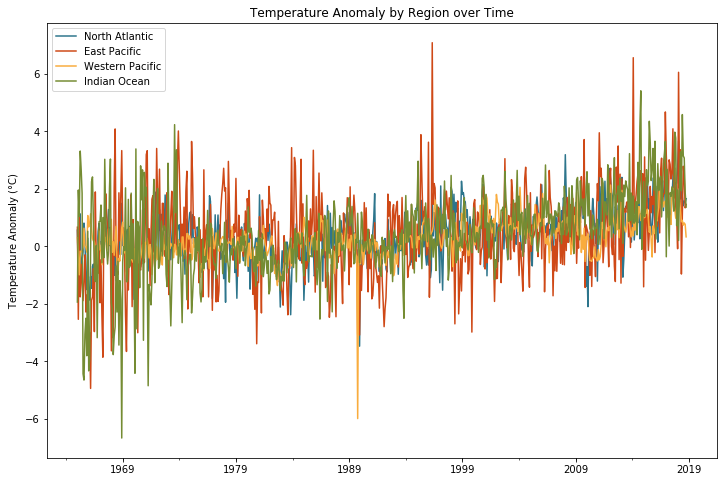

In [11]:
# - Plot
fig, ax = plt.subplots(figsize=default_fig_size)

average_data['diff'].plot(ax=ax, color=colors)

ax.set_ylabel('Temperature Anomaly ($\degree$C)')
ax.set_title('Temperature Anomaly by Region over Time')

plt.show();

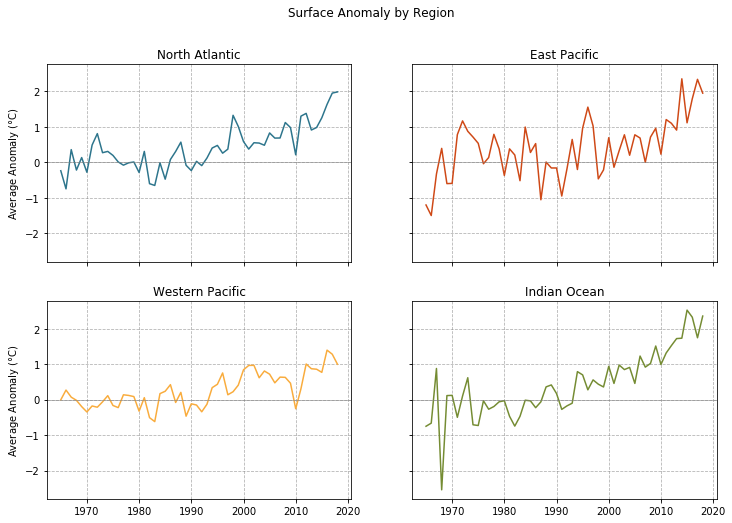

In [12]:
# - Average over years to remove seasonality (Surface)
nm = 'surface'
title = 'Surface Anomaly by Region'

data_to_plot = average_data[nm]
data_to_plot = data_to_plot.groupby(data_to_plot.index.year, axis=0).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, 
                        figsize=default_fig_size)

i_ax = 0
for col in data_to_plot.columns:
    ax = axs.flatten()[i_ax]
    
    data_to_plot.loc[:, col].plot(ax=ax, color=color_dict[col], label=col)

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.grid(True, color='grey', alpha=0.6, linestyle='--')
    
    ax.set_ylabel('Average Anomaly ($\degree$C)')
    ax.set_title(col)
    
    i_ax += 1

fig.suptitle(title)
fig.savefig(os.path.join(media_dir, 'noaa_{}_anomaly_by_region.png'.format(nm)), 
            dpi=output_dpi)
plt.show();

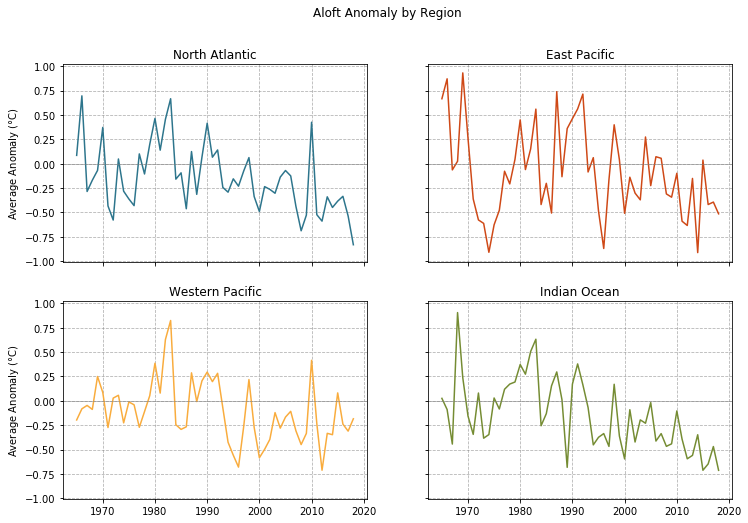

In [13]:
# - Average over years to remove seasonality (Aloft)
nm = 'aloft'
title = 'Aloft Anomaly by Region'

data_to_plot = average_data[nm]
data_to_plot = data_to_plot.groupby(data_to_plot.index.year, axis=0).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, 
                        figsize=default_fig_size)

i_ax = 0
for col in data_to_plot.columns:
    ax = axs.flatten()[i_ax]
    
    data_to_plot.loc[:, col].plot(ax=ax, color=color_dict[col], label=col)

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.grid(True, color='grey', alpha=0.6, linestyle='--')
    
    ax.set_ylabel('Average Anomaly ($\degree$C)')
    ax.set_title(col)
    
    i_ax += 1

fig.suptitle(title)
fig.savefig(os.path.join(media_dir, 'noaa_{}_anomaly_by_region.png'.format(nm)), 
            dpi=output_dpi)
plt.show();

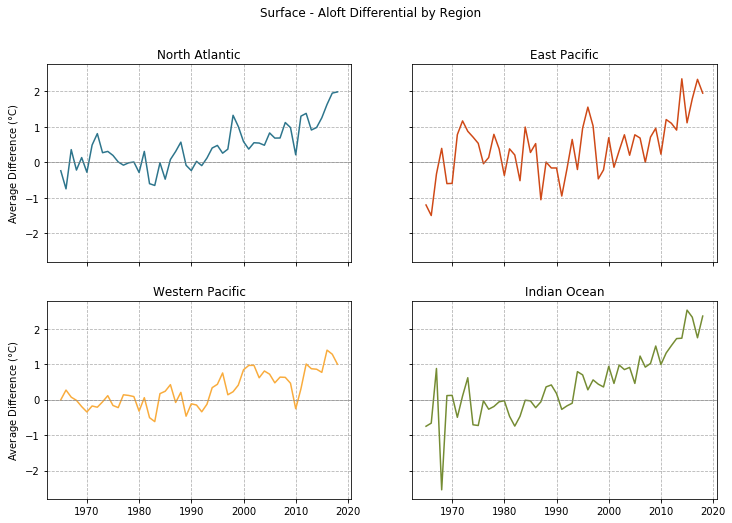

In [14]:
# - Average over years to remove seasonality (Difference)
nm = 'diff'
title = 'Surface - Aloft Differential by Region'

data_to_plot = average_data[nm]
data_to_plot = data_to_plot.groupby(data_to_plot.index.year, axis=0).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, 
                        figsize=default_fig_size)

i_ax = 0
for col in data_to_plot.columns:
    ax = axs.flatten()[i_ax]
    
    data_to_plot.loc[:, col].plot(ax=ax, color=color_dict[col], label=col)

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.grid(True, color='grey', alpha=0.6, linestyle='--')
    
    ax.set_ylabel('Average Difference ($\degree$C)')
    ax.set_title(col)
    
    i_ax += 1

fig.suptitle(title)
fig.savefig(os.path.join(media_dir, 'noaa_{}_anomaly_by_region.png'.format(nm)), 
            dpi=output_dpi)
plt.show();

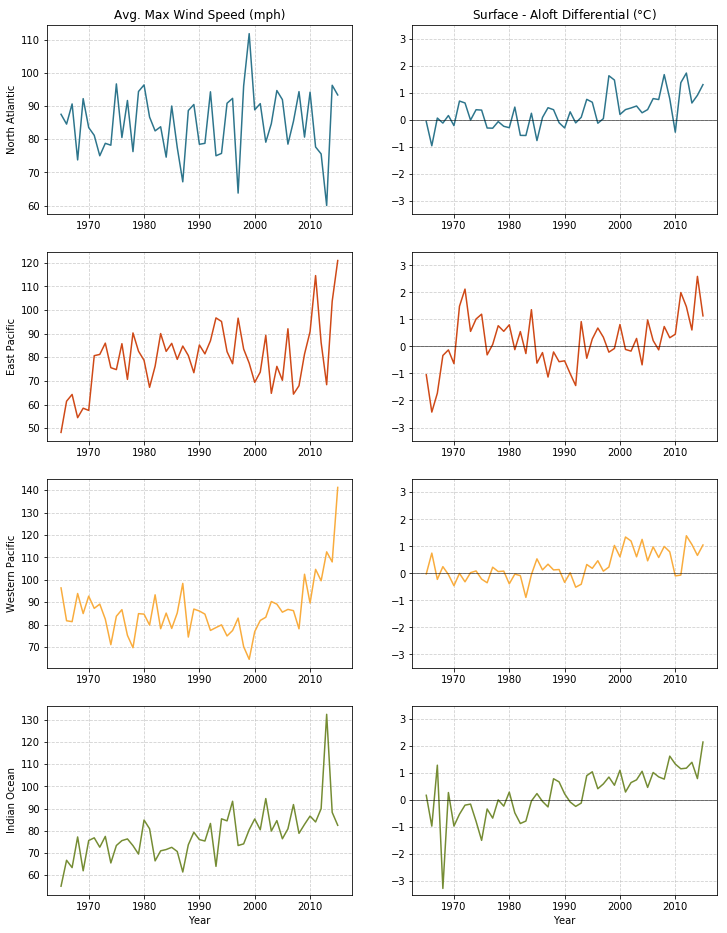

Region,Correlation
North Atlantic,0.068491
East Pacific,0.428032
Western Pacific,0.248027
Indian Ocean,0.414624


In [15]:
# - Average max wind speed & 'wind anomaly' by region
nm = 'diff'
wind_cutoff = 40

avg_max_wind = region_yearly_df.loc[:, ['Region', 'Start Date', 'Max Winds']].copy()

avg_max_wind['Year'] = [x.year for x in avg_max_wind['Start Date']]
avg_max_wind.reset_index(inplace=True)
avg_max_wind.drop(['StormID', 'Start Date'], inplace=True, axis=1)

max_wind = avg_max_wind.groupby(['Year', 'Region'], axis=0) \
                       .max().unstack('Region')
max_wind.columns = max_wind.columns.droplevel(0)

avg_strm_wind = avg_max_wind.where(avg_max_wind > wind_cutoff) \
                            .groupby(['Year', 'Region'], axis=0) \
                            .mean().unstack('Region')
avg_strm_wind.columns = avg_strm_wind.columns.droplevel(0)

avg_max_wind = avg_max_wind.groupby(['Year', 'Region'], axis=0) \
                           .mean().unstack('Region')
avg_max_wind.columns = avg_max_wind.columns.droplevel(0)

storm_data_to_plot = avg_strm_wind
storm_data_to_plot = storm_data_to_plot.loc[1965:, :]

# - NOAA Data
data_to_plot = average_data[nm].copy()
region_periods = {
    'North Atlantic': (6, 11),
    'East Pacific': (5, 11),
    'Western Pacific': (5, 11),
    'Indian Ocean': (5, 10)
}
for region, (s_mon, e_mon) in region_periods.items():
    data_to_plot.loc[(data_to_plot.index.month >= s_mon) 
                     & (data_to_plot.index.month <= e_mon), region] = np.nan
data_to_plot = data_to_plot.groupby(average_data[nm].index.year, axis=0).mean()
data_to_plot = data_to_plot.reindex(storm_data_to_plot.index)

# - Plot
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(figsize_width, 2*figsize_height))

i_r = 0
correlations = dict()
for region in region_cuts.keys():
    storm_data_to_plot.loc[:, region].plot(ax=axs[i_r][0], color=color_dict[region], 
                                           label='Max Wind Speed')
    data_to_plot.loc[:, region].plot(ax=axs[i_r][1], color=color_dict[region], 
                                     label='Surface - Aloft Differential')

    t_corr = pd.concat([storm_data_to_plot.loc[:, region], 
                        data_to_plot.loc[:, region]], axis=1).corr()
    correlations[region] = t_corr.values[0][1]
    
    axs[i_r][0].set_ylabel(region)
    if i_r == 0:
        axs[0][0].set_title('Avg. Max Wind Speed (mph)')
        axs[0][1].set_title('Surface - Aloft Differential ($\degree$C)')
    
    axs[i_r][0].grid(True, linestyle='--', alpha=0.6)
    
    axs[i_r][1].grid(True, linestyle='--', alpha=0.6)
    axs[i_r][1].axhline(0., linewidth=0.5, color='black')
    axs[i_r][1].set_ylim((-3.5, 3.5))
    
    if i_r != 3:
        axs[i_r][0].set_xlabel('')
        axs[i_r][1].set_xlabel('')
    
    i_r += 1

fig.savefig(os.path.join(media_dir, 'avg_max_wind_surface_aloft_diff_by_region.png'), 
            dpi=output_dpi)
plt.show()

# - Correlation Table
corr_tbl = pd.DataFrame(correlations, index=['Correlation']).T
corr_tbl.columns.name = 'Region'

corr_tbl

In [16]:
# - Model data
max_wind = region_yearly_df.loc[:, ['Region', 'Start Date', 'Max Winds']].copy()
max_wind = max_wind.groupby('StormID', axis=0).max()

max_wind['DtKey'] = [(x.year*100 + x.month) for x in max_wind['Start Date']]
max_wind.reset_index(inplace=True)
max_wind.drop(['StormID'], inplace=True, axis=1)

temp_data_surf = average_data['surface'].copy()
temp_data_surf['DtKey'] = [(x.year*100 + x.month) for x in temp_data_surf.index]
temp_data_surf.set_index('DtKey', inplace=True)

temp_data_aloft = average_data['aloft'].copy()
temp_data_aloft['DtKey'] = [(x.year*100 + x.month) for x in temp_data_aloft.index]
temp_data_aloft.set_index('DtKey', inplace=True)

all_data = list()
for region in temp_data_surf.columns:
    t_data = max_wind.loc[max_wind['Region']==region].copy()
    
    t_temps = temp_data_surf.loc[:, region]
    t_temps.name = 'Surface'
    t_out = pd.merge(t_data, t_temps.to_frame(), on='DtKey')
    
    t_temps = temp_data_aloft.loc[:, region]
    t_temps.name = 'Aloft'
    t_out = pd.merge(t_out, t_temps.to_frame(), on='DtKey')
    
    t_out.drop(['DtKey'], axis=1, inplace=True)
    t_out['Diff'] = t_out['Surface'] - t_out['Aloft']
    
    all_data.append(t_out.reindex(['Start Date', 'Region', 'Surface', 'Aloft', 
                                   'Diff', 'Max Winds'], axis=1))

all_data = pd.concat(all_data, axis=0).reset_index().drop('index', axis=1).dropna()
all_data = all_data.where(all_data.loc[:, 'Max Winds'] > wind_cutoff).dropna()

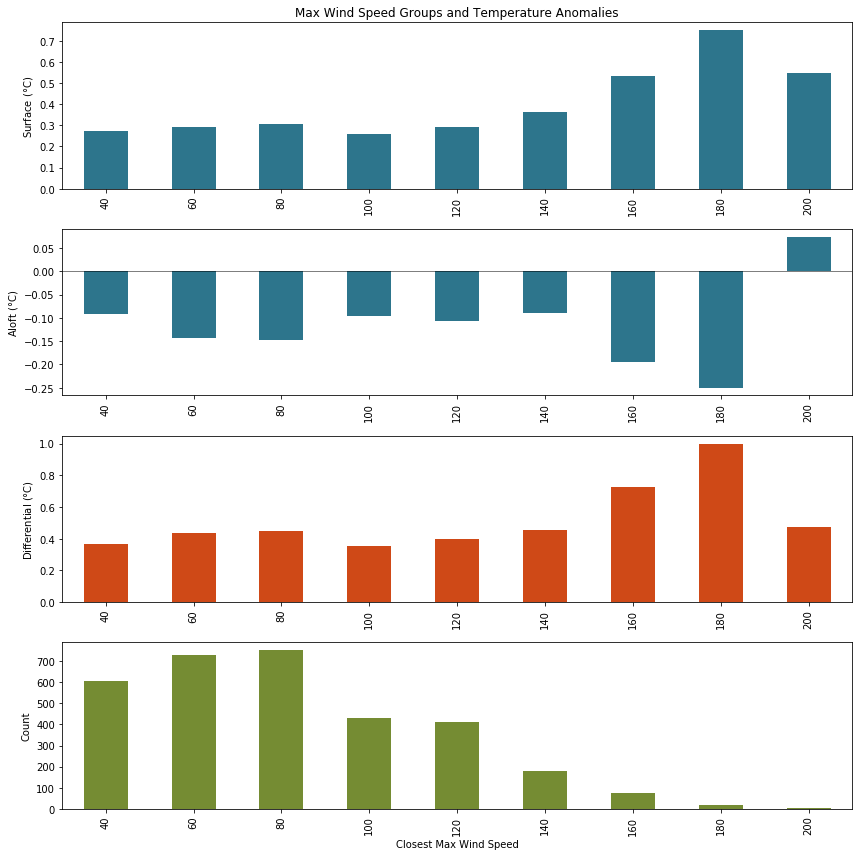

In [17]:
# - Max wind speed bucketing
space_val = 20

fig, axs = plt.subplots(nrows=4, figsize=(figsize_width, figsize_height*1.5))

h_data = all_data.copy()
h_data['Bkt'] = (np.round(h_data.loc[:, 'Max Winds'] / space_val) * space_val).astype(int)
c_data = h_data.groupby('Bkt', axis=0).count()
h_data = h_data.groupby('Bkt', axis=0).mean()

ax = axs[0]
h_data.loc[:, 'Surface'].plot.bar(ax=ax, color=colors[0])
ax.set_title('Max Wind Speed Groups and Temperature Anomalies')
ax.set_xlabel('')
ax.set_ylabel('Surface ($\degree$C)')
ax.axhline(0., color='black', linewidth=0.5)

ax = axs[1]
h_data.loc[:, 'Aloft'].plot.bar(ax=ax, color=colors[0])
ax.set_xlabel('')
ax.set_ylabel('Aloft ($\degree$C)')
ax.axhline(0., color='black', linewidth=0.5)

ax = axs[2]
h_data.loc[:, 'Diff'].plot.bar(ax=ax, color=colors[1])
ax.set_xlabel('')
ax.set_ylabel('Differential ($\degree$C)')
ax.axhline(0., color='black', linewidth=0.5)

ax = axs[3]
c_data.loc[:, 'Diff'].plot.bar(ax=ax, color=colors[3])
ax.set_xlabel('Closest Max Wind Speed')
ax.set_ylabel('Count')

fig.tight_layout()
fig.savefig(os.path.join(media_dir, 'max_wind_buckets_temp_diff.png'))
plt.show();